In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

In [3]:
from google.colab import files
uploaded = files.upload()


Saving Coffee_Shop_Sales[1].xlsx to Coffee_Shop_Sales[1].xlsx


In [4]:
import pandas as pd
data = pd.read_excel("Coffee_Shop_Sales[1].xlsx")


In [5]:
# 1. DATA PREPROCESSING
# Handle missing values
print("Missing values before:")
print(data.isnull().sum())


Missing values before:
transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64


In [10]:
# Fill numeric with median, categorical with mode
data = data.fillna({
    'unit_price': data['unit_price'].median(),
    'store_location': data['store_location'].mode()[0],
    'product_category': data['product_category'].mode()[0]
})
# Remove duplicates
data = data.drop_duplicates()

# Remove outliers in unit_price using z-score
from scipy.stats import zscore

z_scores = np.abs(zscore(data['unit_price']))
data = data[z_scores < 3]

# Convert date/time to datetime
data['transaction_date'] = pd.to_datetime(data['transaction_date'])
data['transaction_time'] = pd.to_datetime(data['transaction_time'], format='%H:%M:%S').dt.time

# Create Month, Day, Hour features
data['Month'] = data['transaction_date'].dt.to_period('M')
data['DayOfWeek'] = data['transaction_date'].dt.day_name()
data['Hour'] = pd.to_datetime(data['transaction_time'], format='%H:%M:%S').dt.hour

# Add Sales column
data['Sales'] = data['transaction_qty'] * data['unit_price']

data

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,Month,DayOfWeek,Hour,Sales
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.00,Coffee,Gourmet brewed coffee,Ethiopia Rg,2023-01,Sunday,7,6.00
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01,Sunday,7,6.20
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,2023-01,Sunday,7,9.00
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2023-01,Sunday,7,2.00
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01,Sunday,7,6.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149111,149452,2023-06-30,20:18:41,2,8,Hell's Kitchen,44,2.50,Tea,Brewed herbal tea,Peppermint Rg,2023-06,Friday,20,5.00
149112,149453,2023-06-30,20:25:10,2,8,Hell's Kitchen,49,3.00,Tea,Brewed Black tea,English Breakfast Lg,2023-06,Friday,20,6.00
149113,149454,2023-06-30,20:31:34,1,8,Hell's Kitchen,45,3.00,Tea,Brewed herbal tea,Peppermint Lg,2023-06,Friday,20,3.00
149114,149455,2023-06-30,20:57:19,1,8,Hell's Kitchen,40,3.75,Coffee,Barista Espresso,Cappuccino,2023-06,Friday,20,3.75


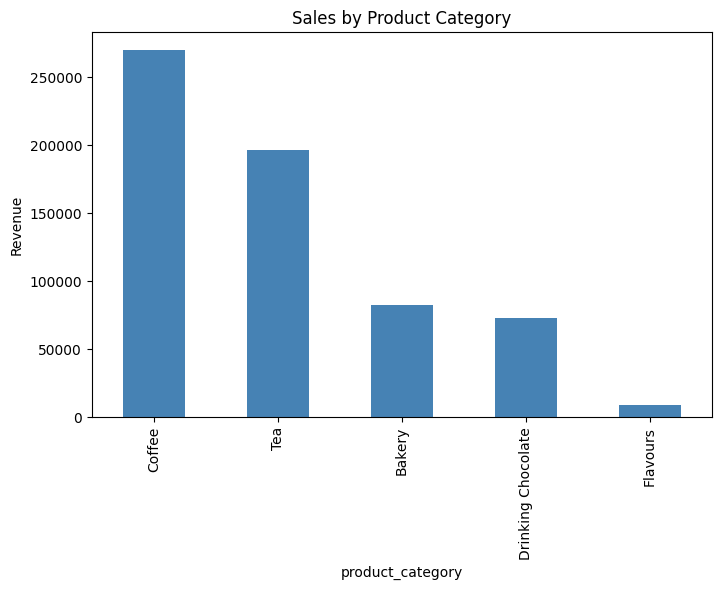

In [11]:

#2. EXPLORATORY DATA ANALYSIS(EDA)
# Sales by Product Category
sales_by_category = data.groupby('product_category')['Sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sales_by_category.plot(kind='bar', color='steelblue')
plt.title("Sales by Product Category")
plt.ylabel("Revenue")
plt.show()

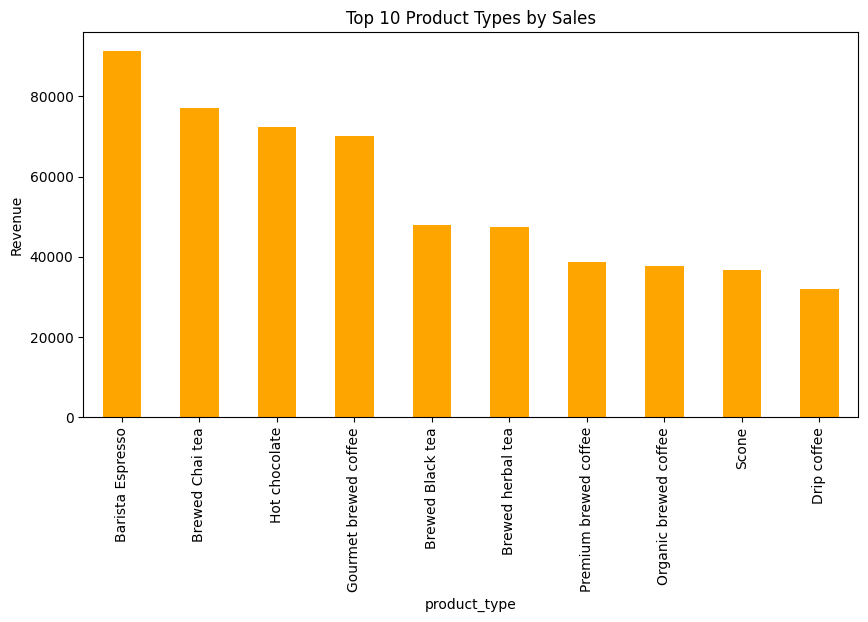

In [12]:
# Sales by Product Type
sales_by_type = data.groupby('product_type')['Sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sales_by_type.plot(kind='bar', color='orange')
plt.title("Top 10 Product Types by Sales")
plt.ylabel("Revenue")
plt.show()

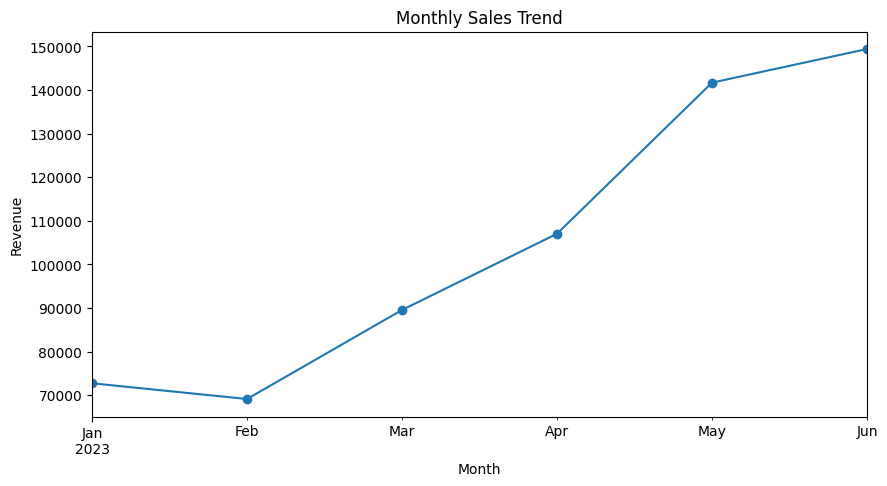

In [13]:
# Monthly Trends
monthly_sales = data.groupby('Month')['Sales'].sum()
plt.figure(figsize=(10,5))
monthly_sales.plot(kind='line', marker='o')
plt.title("Monthly Sales Trend")
plt.ylabel("Revenue")
plt.show()

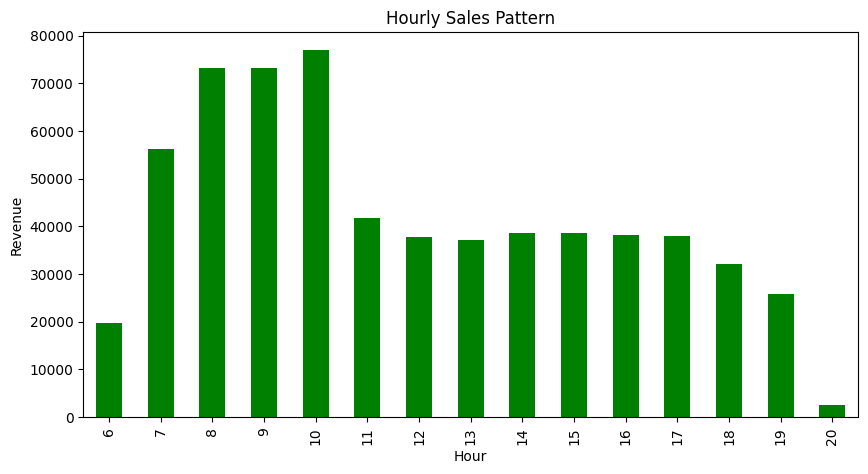

In [14]:

# Hourly Sales Pattern
hourly_sales = data.groupby('Hour')['Sales'].sum()
plt.figure(figsize=(10,5))
hourly_sales.plot(kind='bar', color='green')
plt.title("Hourly Sales Pattern")
plt.ylabel("Revenue")
plt.show()


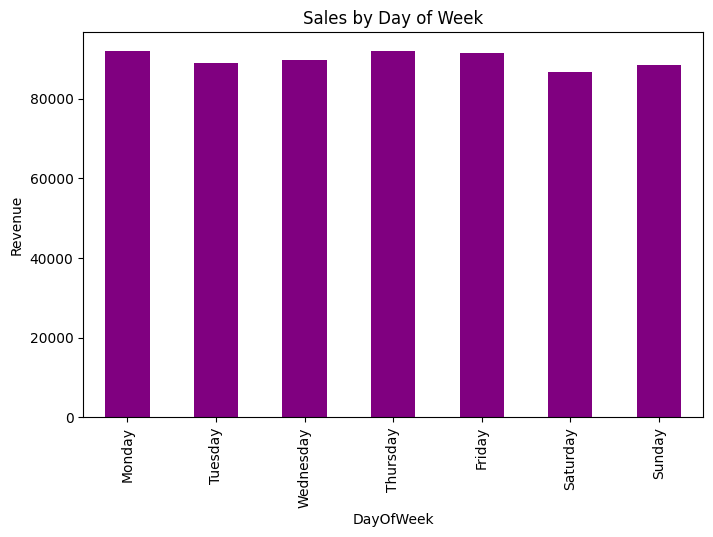

In [15]:
# Daily Sales Pattern
weekday_sales = data.groupby('DayOfWeek')['Sales'].sum().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.figure(figsize=(8,5))
weekday_sales.plot(kind='bar', color='purple')
plt.title("Sales by Day of Week")
plt.ylabel("Revenue")
plt.show()

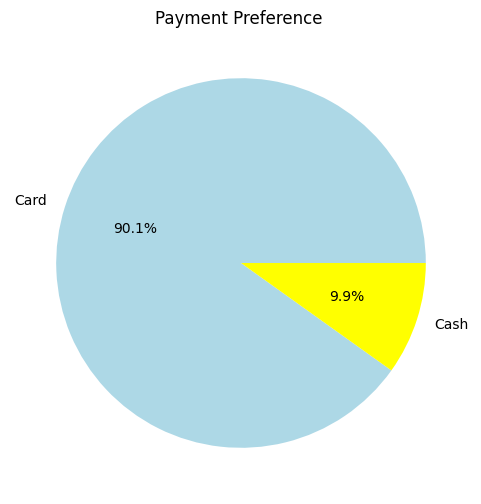

In [19]:
# payment_type column
np.random.seed(42)
data['payment_type'] = np.random.choice(['Card','Cash'], size=len(data), p=[0.9,0.1])

payment_pref = data['payment_type'].value_counts(normalize=True) * 100
plt.figure(figsize=(6,6))
payment_pref.plot(kind='pie', autopct='%1.1f%%', colors=['lightblue','yellow'])
plt.title("Payment Preference ")
plt.ylabel("")
plt.show()

Linear Regression Forecast Evaluation:
MSE: 191078.93, RMSE: 437.13, R²: -0.09


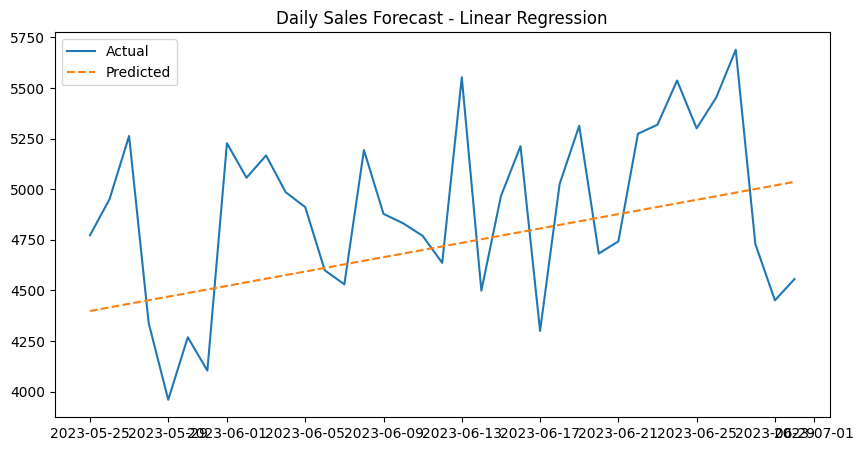

In [20]:
#3. FORECASTING
# Aggregate daily sales
daily_sales = data.groupby('transaction_date')['Sales'].sum()

# Prepare dataset for regression
X = np.array(range(len(daily_sales))).reshape(-1,1)
y = daily_sales.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Forecast Evaluation:")
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

plt.figure(figsize=(10,5))
plt.plot(daily_sales.index[-len(y_test):], y_test, label="Actual")
plt.plot(daily_sales.index[-len(y_test):], y_pred, label="Predicted", linestyle='dashed')
plt.legend()
plt.title("Daily Sales Forecast - Linear Regression")
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


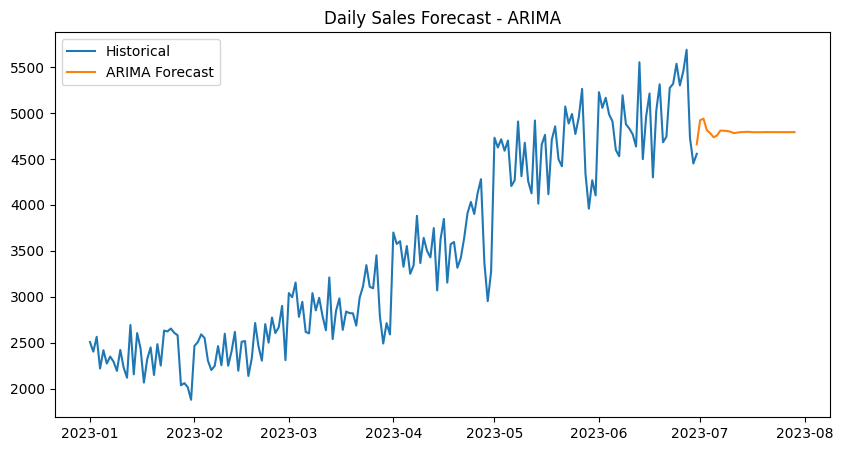

In [21]:
# ARIMA for Time Series Forecasting

model_arima = ARIMA(daily_sales, order=(5,1,0))
model_fit = model_arima.fit()
forecast = model_fit.forecast(steps=30)

plt.figure(figsize=(10,5))
plt.plot(daily_sales.index, daily_sales, label='Historical')
plt.plot(pd.date_range(daily_sales.index[-1], periods=30, freq='D'), forecast, label='ARIMA Forecast')
plt.legend()
plt.title("Daily Sales Forecast - ARIMA")
plt.show()